In [89]:
from sklift.datasets import fetch_x5
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, CatBoostRegressor
import lightgbm as LGBm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

# load date

In [25]:
dataset = fetch_x5()
data, target, treatment = dataset.data, dataset.target, dataset.treatment

# data - dictionary-like object
# data contains general info about clients:
clients = data.clients

# data contains a subset of clients for training:
train = data.train

# data contains a clients’ purchase history prior to communication.
purchases = data.purchases

# research date

In [26]:
clients.head()

,client_id,first_issue_date,first_redeem_date,age,gender
0,000012768d,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U
1,000036f903,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F
2,000048b7a6,2018-12-15 13:33:11,NaN,68,F
3,000073194a,2017-05-23 12:56:14,2017-11-24 11:18:01,60,F
4,00007c7133,2017-05-22 16:17:08,2018-12-31 17:17:33,67,U


In [27]:
train.head()

,client_id
0,000012768d
1,000036f903
2,00010925a5
3,0001f552b0
4,00020e7b18


In [28]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45786568 entries, 0 to 45786567
Data columns (total 13 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   client_id                object 
 1   transaction_id           object 
 2   transaction_datetime     object 
 3   regular_points_received  float64
 4   express_points_received  float64
 5   regular_points_spent     float64
 6   express_points_spent     float64
 7   purchase_sum             float64
 8   store_id                 object 
 9   product_id               object 
 10  product_quantity         float64
 11  trn_sum_from_iss         float64
 12  trn_sum_from_red         float64
dtypes: float64(8), object(5)
memory usage: 4.4+ GB


In [29]:
target.head()

0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int64

In [30]:
treatment.head()

0    0
1    1
2    1
3    1
4    1
Name: treatment_flg, dtype: int64

In [31]:
print(clients.shape, train.shape, target.shape, treatment.shape, purchases.shape)

(400162, 5) (200039, 1) (200039,) (200039,) (45786568, 13)


# study

## Agregation data

In [ ]:
SKIP = all(
    Path(p).exists()
    for p in ("./data/X.csv", "./data/T.csv", "./data/Y.csv")
)

In [ ]:
if not SKIP:
    df_train_target_treatment = pd.DataFrame({"client_id": train["client_id"].tolist(),
                                            "target": target,
                                            "treatment": treatment})

In [ ]:
if not SKIP:
    split_client = np.array_split(df_train_target_treatment["client_id"], 10)
    agg_clients = []

    for ids in split_client:
        chunk = purchases[purchases["client_id"].isin(ids)]

        g = chunk.groupby("client_id").agg(
            txn_cnt=('purchase_sum', 'size'),

            purchase_sum_total=('purchase_sum', 'sum'),
            purchase_sum_mean=('purchase_sum', 'mean'),
            purchase_sum_std=('purchase_sum', 'std'),
            purchase_sum_max=('purchase_sum', 'max'),

            iss_sum=('trn_sum_from_iss', 'sum'),
            red_sum=('trn_sum_from_red', 'sum'),

            regular_points_received_sum=('regular_points_received', 'sum'),
            express_points_received_sum=('express_points_received', 'sum'),

            regular_points_spent_sum=('regular_points_spent', 'sum'),
            express_points_spent_sum=('express_points_spent', 'sum'),

            product_quantity_total=('product_quantity', 'sum'),
        )

        g['points_received_total'] = (
            g['regular_points_received_sum'] + g['express_points_received_sum']
        )

        g['points_spent_total'] = (
            g['regular_points_spent_sum'] + g['express_points_spent_sum']
        )

        agg_clients.append(g)

c:\Users\Alexey\Documents\programming\VSCode\ML\uplift\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:54: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


In [ ]:
if not SKIP: agg_feature = pd.concat(agg_clients).groupby(level=0).sum().reset_index()

In [ ]:
if not SKIP:
    df_after_agg = df_train_target_treatment.merge(
        agg_feature,
        on='client_id',
        how='left'
    )


In [ ]:
if not SKIP: df_after_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200039 entries, 0 to 200038
Data columns (total 17 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   client_id                    200039 non-null  object 
 1   target                       200039 non-null  int64  
 2   treatment                    200039 non-null  int64  
 3   txn_cnt                      200039 non-null  int64  
 4   purchase_sum_total           200039 non-null  float64
 5   purchase_sum_mean            200039 non-null  float64
 6   purchase_sum_std             200039 non-null  float64
 7   purchase_sum_max             200039 non-null  float64
 8   iss_sum                      200039 non-null  float64
 9   red_sum                      200039 non-null  float64
 10  regular_points_received_sum  200039 non-null  float64
 11  express_points_received_sum  200039 non-null  float64
 12  regular_points_spent_sum     200039 non-null  float64
 13 

## Spliting data

In [ ]:
if not SKIP:
    X = df_after_agg.drop(columns=["target", "treatment", "client_id"])
    T = df_after_agg["treatment"]
    Y = df_after_agg["target"]

    # X.to_csv("./data/X.csv")
    # Y.to_csv("./data/Y.csv")
    # T.to_csv("./data/T.csv")
else:
    X = pd.read_csv("./data/X.csv")
    Y = pd.read_csv("./data/Y.csv")
    T = pd.read_csv("./data/T.csv")

In [80]:
train_x, valid_x, \
train_y, valid_y, \
treatment_x, treatment_y = train_test_split(
    X, Y, T,
    test_size=0.2,
    random_state=42
)


In [81]:
X_treat = train_x[treatment_x == 1]
y_treat = train_y[treatment_x == 1]

X_ctrl = train_x[treatment_x == 0]
y_ctrl = train_y[treatment_x == 0]


## Study, T-leaner

In [101]:
mu1 = CatBoostClassifier(
    iterations=300,
    depth=6,
    learning_rate=0.05,
    loss_function='Logloss',
    verbose=False
)
mu0 = CatBoostClassifier(
    iterations=300,
    depth=6,
    learning_rate=0.05,
    loss_function='Logloss',
    verbose=False
)

mu1.fit(X_treat, y_treat)
mu0.fit(X_ctrl, y_ctrl)


In [102]:
p1 = mu1.predict_proba(valid_x)[:, 1]
p0 = mu0.predict_proba(valid_x)[:, 1]

uplift_valid_T = p1 - p0


In [103]:
print(f"Среднее: {round(uplift_valid_T.mean(), 4)}, STD: {round(uplift_valid_T.std(), 4)}")


Среднее: 0.0313, STD: 0.0412


## Study, X-leaner

In [104]:
# предсказания μ-моделей на train
mu0_hat_train = mu0.predict_proba(train_x)[:, 1]
mu1_hat_train = mu1.predict_proba(train_x)[:, 1]

D1 = train_y[treatment_x == 1] - mu0_hat_train[treatment_x == 1]
D0 = mu1_hat_train[treatment_x == 0] - train_y[treatment_x == 0]

In [105]:
tau1 = CatBoostRegressor(
    iterations=300,
    depth=6,
    learning_rate=0.05,
    loss_function='RMSE',
    verbose=False
)
tau0 = CatBoostRegressor(
    iterations=300,
    depth=6,
    learning_rate=0.05,
    loss_function='RMSE',
    verbose=False
)

tau1.fit(train_x[treatment_x == 1], D1)
tau0.fit(train_x[treatment_x == 0], D0)


In [106]:
uplift_valid_X = 0.5 * (
    tau1.predict(valid_x) +
    tau0.predict(valid_x)
)


In [107]:
print(f"Mean X-leaner: {round(uplift_valid_X.mean(), 4)}, STD: {round(uplift_valid_X.std(), 4)}")

Mean X-leaner: 0.0312, STD: 0.0337


# Validation

In [ ]:
def valid(uplift_valid):
    df_val = pd.DataFrame({
        'uplift': uplift_valid,
        'treatment': treatment_y.values,
        'y': valid_y.values
    })

    df_val = df_val.sort_values('uplift', ascending=False).reset_index(drop=True)

    df_val['treat_y'] = df_val['y'] * df_val['treatment']
    df_val['ctrl_y']  = df_val['y'] * (1 - df_val['treatment'])

    df_val['cum_treat_y'] = df_val['treat_y'].cumsum()
    df_val['cum_ctrl_y']  = df_val['ctrl_y'].cumsum()

    df_val['cum_treat_n'] = df_val['treatment'].cumsum()
    df_val['cum_ctrl_n']  = (1 - df_val['treatment']).cumsum()

    df_val['cum_uplift'] = (
        df_val['cum_treat_y'] / df_val['cum_treat_n'].replace(0, np.nan)
        -
        df_val['cum_ctrl_y'] / df_val['cum_ctrl_n'].replace(0, np.nan)
    )

    auuc = df_val['cum_uplift'].mean()
    print(f"AUUC: {round(auuc, 4)}")

    random_uplift = (
        (df_val['treat_y'].sum() / df_val['treatment'].sum())
        -
        (df_val['ctrl_y'].sum() / (1 - df_val['treatment']).sum())
    )

    qini = (df_val['cum_uplift'] - random_uplift).mean()
    print(f"QINI: {round(qini, 4)}")

    x = np.arange(1, len(df_val) + 1) / len(df_val)

    plt.figure(figsize=(8, 5))
    plt.plot(x, df_val['cum_uplift'])
    plt.axhline(0)
    plt.xlabel('Доля клиентов (top-k)')
    plt.ylabel('Кумулятивный uplift')
    plt.title('Uplift curve')
    plt.show()



T-leaner:
AUUC: 0.0582
QINI: 0.0214


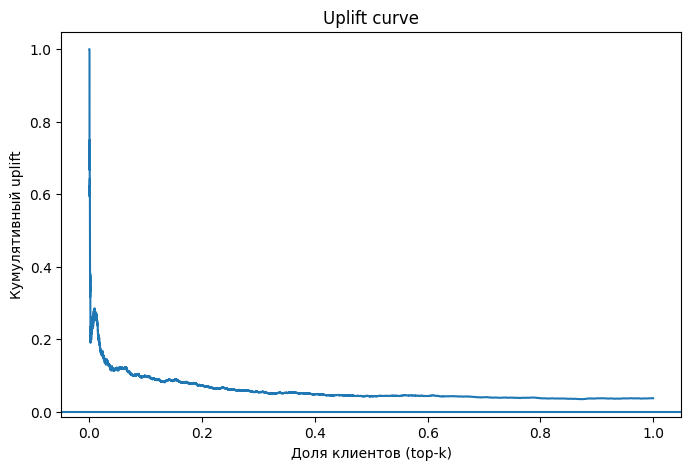

K-opt: 0.45895820835832835

X-leaner
AUUC: 0.0635
QINI: 0.0267


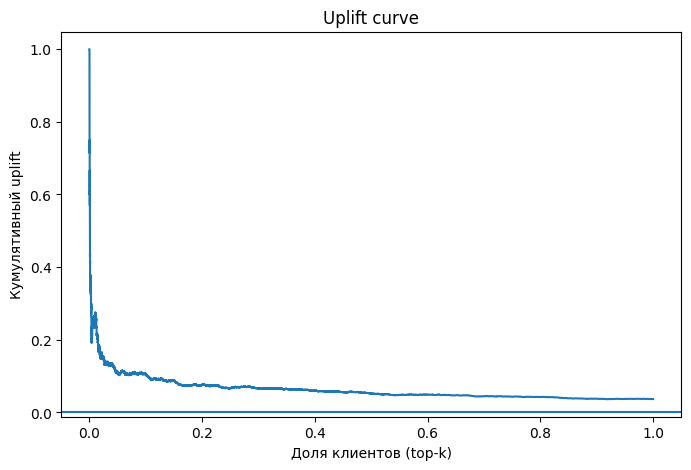

K-opt: 0.7991651669666067


In [127]:
print("T-leaner:")
valid(uplift_valid_T)
print("\nX-leaner")
valid(uplift_valid_X)


In [ ]:
ARPU = X["purchase_sum_mean"].mean()
cost = 20

In [141]:
def money(uplift_valid, ARPU = 500, cost = 50):
    df = pd.DataFrame({
        'uplift': uplift_valid,
        'treatment': treatment_y.values,
        'y': valid_y.values
    })

    df =  df.sort_values('uplift', ascending=False).reset_index(drop=True)

    df['exp_profit'] = df['uplift'] * ARPU - cost

    # сортировка уже сделана по uplift
    df['cum_profit'] = df['exp_profit'].cumsum()

    x = np.arange(1, len(df) + 1) / len(df)

    plt.figure(figsize=(8, 5))
    plt.plot(x, df['cum_profit'])
    plt.axhline(0)
    plt.xlabel('Доля клиентов (top-k)')
    plt.ylabel('Кумулятивная ожидаемая прибыль')
    plt.title('Expected profit curve')
    plt.show()

    k_idx = df['cum_profit'].idxmax()
    k_profit = k_idx / len(df)
    print(k_profit)

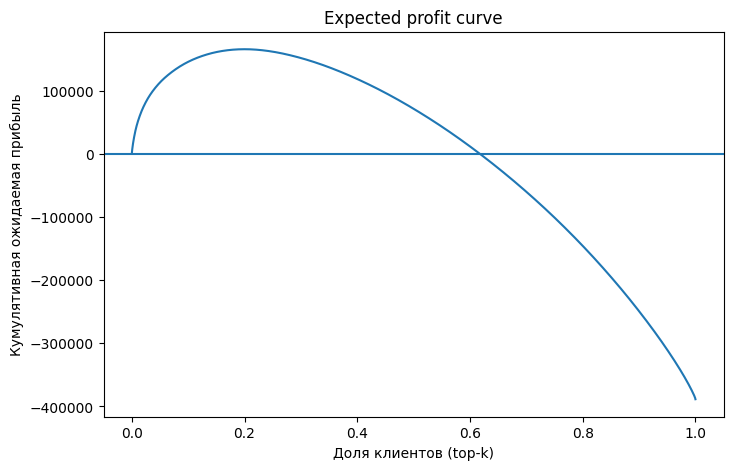

0.2001599680063987


In [143]:
money(uplift_valid_X, ARPU, 30)